## Preprocessing for Re-running ACL Paper with larger dataset

In [5]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys

In [6]:
#!pip install numpy pandas matplotlib sklearn

In [7]:
# 1. Load and Merge Datasets
#NEO R01 Dataset
maindf_v5 = pd.read_csv("Data/maindf_v5.csv")
maindf_v5.drop(columns=["Unnamed: 0", "context_id"], inplace=True)
maindf_v5 = maindf_v5.assign(db= "R01")
maindf_v5.rename(columns={"ID":"mid","participant_id":"pid", "languages":"language", "Urgency":"urgency"}, inplace=True)
maindf_v5 = maindf_v5.assign(pid = maindf_v5.pid+714)

#NEO Pilot Dataset
maindf_v3 = pd.read_csv("Data/maindf_v3.csv")
maindf_v3.drop(columns=["Unnamed: 0"], inplace=True)
maindf_v3 = maindf_v3.assign(db= "PILOT")

#merge datasets
maindf_v7 = pd.concat([maindf_v3, maindf_v5]).reset_index()
maindf_v7.drop(columns=["index"], inplace=True)
#reset mid as the new index system
maindf_v7 = maindf_v7.assign(mid = maindf_v7.index + 1) #start counting messages at 1


maindf_v7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220569 entries, 0 to 220568
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   mid       220569 non-null  int64  
 1   pid       220569 non-null  int64  
 2   created   220569 non-null  object 
 3   sent_by   220569 non-null  object 
 4   language  133542 non-null  object 
 5   text      220560 non-null  object 
 6   urgency   220569 non-null  int64  
 7   db        220569 non-null  object 
 8   label     161735 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 15.1+ MB


In [8]:
maindf_v5.created.min(), maindf_v5.created.max()

('2020-09-09 05:00:05.125678', '2022-04-05 10:00:43.806452')

In [9]:
#Remove NaN messages
maindf_v7 = maindf_v7[maindf_v7.text.notnull()]

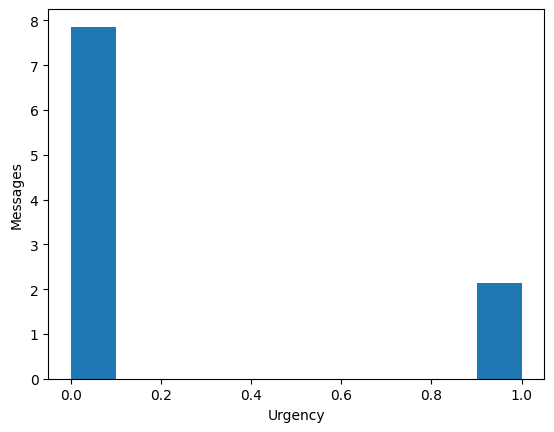

In [10]:
#calculate label
maindf_v7 = maindf_v7.assign(label = np.where(((maindf_v7.urgency == 1) | (maindf_v7.urgency == 2)), 1, 
                                             np.where(( (maindf_v7.urgency == 3) | (maindf_v7.urgency == 4) | (maindf_v7.urgency == 5)), 0, -2)))
plt.hist(maindf_v7[maindf_v7.label >= 0].label, density=True)
plt.ylabel('Messages')
plt.xlabel('Urgency');
plt.show()

In [11]:
maindf_v3.pid.max(), maindf_v5.pid.min()

(800, 801)

system         112220
participant     65572
nurse           42768
Name: sent_by, dtype: int64


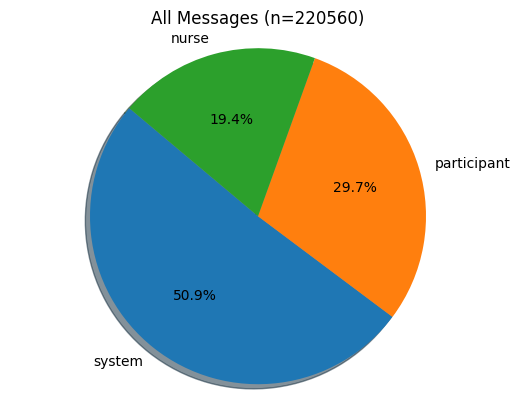

In [12]:
#Pie Chart of Messages by sent_by
print(maindf_v7.sent_by.value_counts())
labels = maindf_v7.sent_by.value_counts().keys()
sizes = maindf_v7.sent_by.value_counts()   
explode = (0, 0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("All Messages (n={n_items})".format(n_items=len(maindf_v7.index)))
plt.show()

In [32]:
maindf_v7.lang.value_counts(dropna=False)

NaN              87027
english          69593
swahili          49545
luo               8979
Code-Switched     3351
sheng             2065
Name: lang, dtype: int64

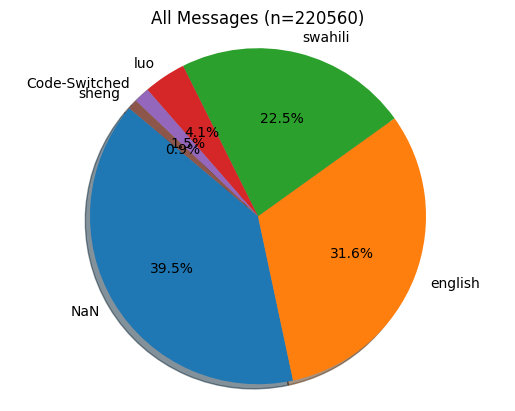

In [13]:
maindf_v7 = maindf_v7.assign(lang = np.where(maindf_v7.language == 'luo', 'luo', 
                                       np.where(maindf_v7.language == 'swahili', 'swahili',
                                       np.where(maindf_v7.language == 'english', 'english',
                                       np.where(maindf_v7.language == 'sheng', 'sheng', 
                                                np.where(maindf_v7.language.isnull(), 'NaN', 'Code-Switched'))))
                                      ))
maindf_v7.lang.value_counts(dropna=False)
labels = maindf_v7.lang.value_counts().keys()
sizes = maindf_v7.lang.value_counts()   
explode = (0, 0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("All Messages (n={n_items})".format(n_items=len(maindf_v7.index)))
plt.show()

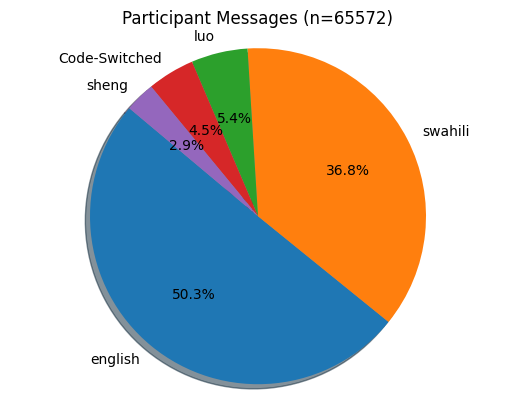

In [14]:
#Participant messages by language
participants_df = maindf_v7[maindf_v7.sent_by == "participant"]

participants_df = participants_df.assign(lang = np.where(participants_df.language == 'luo', 'luo', 
                                       np.where(participants_df.language == 'swahili', 'swahili',
                                       np.where(participants_df.language == 'english', 'english',
                                       np.where(participants_df.language == 'sheng', 'sheng', 
                                                'Code-Switched')))
                                      ))
participants_df.lang.value_counts(dropna=False)
labels = participants_df.lang.value_counts().keys()
sizes = participants_df.lang.value_counts()   
explode = (0, 0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Participant Messages (n={n_items})".format(n_items=len(participants_df.index)))
plt.show()

In [15]:
#2. System messages
system_df = maindf_v7[maindf_v7['sent_by'] == 'system']
system_df = system_df[["mid", "text", "pid"]]
system_df = system_df.assign(system_text = system_df.text)
system_df = system_df.assign(system_pid = system_df.pid)
system_df = system_df[["mid", "system_text", "system_pid"]]
system_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112220 entries, 0 to 220568
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   mid          112220 non-null  int64 
 1   system_text  112220 non-null  object
 2   system_pid   112220 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [16]:
#Sort by participant and date
maindf_v7 = maindf_v7.sort_values(by=['pid', 'created'], ascending=[True, True])
maindf_v7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220560 entries, 260 to 220568
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   mid       220560 non-null  int64 
 1   pid       220560 non-null  int64 
 2   created   220560 non-null  object
 3   sent_by   220560 non-null  object
 4   language  133533 non-null  object
 5   text      220560 non-null  object
 6   urgency   220560 non-null  int64 
 7   db        220560 non-null  object
 8   label     220560 non-null  int32 
 9   lang      220560 non-null  object
dtypes: int32(1), int64(3), object(6)
memory usage: 17.7+ MB


In [17]:
len(maindf_v7.pid.unique())

2523

In [18]:
labelled_df = maindf_v7[maindf_v7.label >= 0]
len(labelled_df.pid.unique()), len(labelled_df.index)

(772, 11129)

0    8746
1    2383
Name: label, dtype: int64


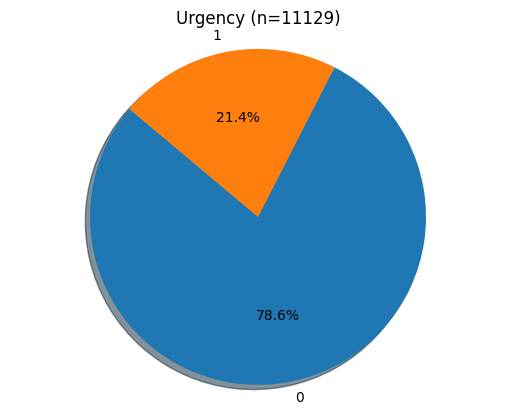

In [19]:
print(labelled_df.label.value_counts())

labels = labelled_df.label.value_counts().keys()
sizes = labelled_df.label.value_counts()   
explode = (0, 0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Urgency (n={n_items})".format(n_items=len(labelled_df.index)))
plt.show()

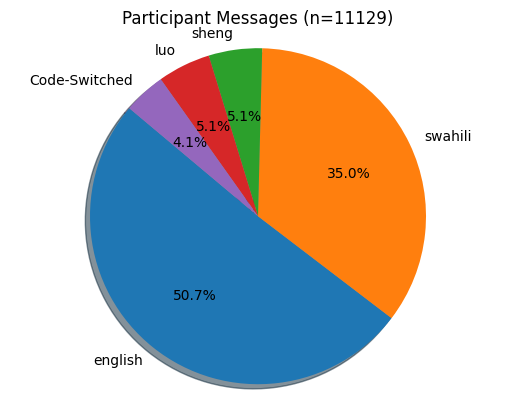

In [20]:
#### LABELLED Data ################################
#Participant messages by language
labelled_part_df = labelled_df[labelled_df.sent_by == "participant"]

labelled_part_df = labelled_part_df.assign(lang = np.where(labelled_part_df.language == 'luo', 'luo', 
                                       np.where(labelled_part_df.language == 'swahili', 'swahili',
                                       np.where(labelled_part_df.language == 'english', 'english',
                                       np.where(labelled_part_df.language == 'sheng', 'sheng', 
                                                'Code-Switched')))
                                      ))
labelled_part_df.lang.value_counts(dropna=False)
labels = labelled_part_df.lang.value_counts().keys()
sizes = labelled_part_df.lang.value_counts()   
explode = (0, 0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Participant Messages (n={n_items})".format(n_items=len(labelled_part_df.index)))
plt.show()

In [33]:
labelled_part_df.lang.value_counts(dropna=False)

english          5646
swahili          3893
sheng             572
luo               566
Code-Switched     452
Name: lang, dtype: int64

In [35]:
labelled_part_df.lang.value_counts(dropna=False, normalize = True)

english          0.507323
swahili          0.349807
sheng            0.051397
luo              0.050858
Code-Switched    0.040615
Name: lang, dtype: float64

In [26]:
#Mean number of characters in a message
maindf_v7 = maindf_v7.assign(chars = maindf_v7.text.str.len())


In [30]:
maindf_v7.groupby("sent_by").agg({"chars":['mean','std'] })
#maindf_v7.chars

chars            
                   mean         std
sent_by                            
nurse         97.904461  103.544162
participant   36.507457   39.793503
system       257.292310  102.656769

### 3. System Context

In [23]:
#3. Calculate context
def generateContext(df):
    df['context_id'] = 0
    context_id = 0
    for row_index, row in df.iterrows():
        if(row.sent_by == "system"):
            context_id = row.mid
        df.at[row_index, 'context_id'] = context_id
    return df
        
maindf_grouped = maindf_v7.groupby("pid")

df_final = pd.DataFrame()
for group_name, group in maindf_grouped:
    df = generateContext(group)
    df_final=df_final.append(df)

<ipython-input-23-dd5a2a4d53e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['context_id'] = 0


In [ ]:
pd.set_option("display.max_rows", None)
df_final[df_final.pid==861]

In [ ]:
# Participants messages - System Context
participant_df = df_final[df_final['sent_by'] == 'participant']
#Participants - add system context
part_context = pd.merge(participant_df, system_df, how="left", left_on="context_id", right_on="mid")
#dealing with all messages, including those without preceding context
part_context['contextualized'] = np.where(part_context.context_id == 0, part_context.text, part_context.text+" "+part_context.system_text)



In [ ]:
part_context.rename(columns={"mid_x":"mid", "mid_y":"system_mid"}, inplace=True)
part_context.rename(columns={"contextualized":"system_context"}, inplace=True)
part_context.head()
#participant_context.to_csv("Data/system_context_all_v5.csv")

In [ ]:
#check that system partID and participant ID are matching
system_none = part_context[part_context["pid"] != part_context["system_pid"]]
system_none.to_csv("Data/queries/messages_no_sys_context.csv")
system_none.shape

### 4. Nurse Context

In [ ]:
#4. Nurse context
#Nurse-or-system context
def parentMessage(df):
    responded = list()
    df_size = len(df)
    for row in df.itertuples():
        i=0
        if(row.sent_by == "participant"):
            #print(row.Index-1)
            #print(i)
            while i <= row.Index:
                prev_msg = df.iloc[row.Index-i]
                if(prev_msg.sent_by == "system" or prev_msg.sent_by == "nurse" ):
                    responded.append(prev_msg.text)
                    break
                #print(i)
                i = i + 1
            else:
                responded.append("")

        else:
            responded.append(row.sent_by)

        #print(row.Index, row.pid, row.timestamp) 

    return responded


In [ ]:
#df_final.info()
df_groups = df_final.groupby("pid")
pids = df_final.pid.unique()
df_final2 = pd.DataFrame()

#df['nurse_system_context'] = parentMessage(df)
#parentMessage(df)

for c in pids:
    df = df_groups.get_group(c).reset_index()
    nurse_context = parentMessage(df)
    if len(nurse_context) < len(df):
        print(c, len(nurse_context), len(df))
        break
    else:
        df['nurse_system_context'] = nurse_context
        df_final2=df_final2.append(df)


In [ ]:
#df = df_groups.get_group(1).reset_index()
#parentMessage(df)
pids = df_final.pid.unique()
len(pids)

In [ ]:
#df_final2[(df_final2.sent_by=="participant")][["mid", "pid", "label", "sent_by", "text", "nurse_system_context"]]
#np.savetxt("Data/pids.csv", pids, delimiter=",")
maindf_v7 = df_final2
maindf_v7.info()

In [ ]:
part_context[["mid", "pid", "text"]].head(20)

In [ ]:
part_nurse_context = df_final2[(df_final2.sent_by=="participant")]
part_nurse_context = part_nurse_context.assign(nurse_context = part_nurse_context.text+" "+part_nurse_context.nurse_system_context)
nurse_context_df = part_nurse_context[["mid", "nurse_context"]]

#merge with part_context_df
part_context = part_context.merge(nurse_context_df, on='mid', how='inner' )
part_context.to_csv("Data/version_7/part_all_context_v7.csv")


In [ ]:
#part_context.drop(columns=["nurse_context_x","nurse_context_y"], inplace=True)
part_context.info()

## 4. Generate Datasets

In [ ]:
#get unlabeled system_context messages
context_unlbl = part_context[part_context.label < 0]

#get labeled system_context messages
context_lbl = part_context[part_context.label >= 0]


#System Context train test split
train_df, remain_df = train_test_split(context_lbl, random_state=42, train_size=0.7, stratify=context_lbl.label.values)
test_df, dev_df = train_test_split(remain_df, random_state=42, train_size=0.7, stratify=remain_df.label.values)


#formulate system context pretraining dataset
context_pretrain_df = pd.concat([context_unlbl, train_df])
pretrain_train, pretrain_validation = train_test_split(context_pretrain_df, test_size=0.2, random_state=42)


pretrain_train.shape, pretrain_validation.shape

In [ ]:
context_unlbl.to_csv("Data/version_7/context_all_unlbl_v7.csv")
context_lbl.to_csv("Data/version_7/context_all_lbl_v7.csv")

In [ ]:
#Pretrain context datasets
#No context pretrain datasets
no_pretrain_df = context_pretrain_df[["mid", "pid", "text"]]
no_pretrain_df.to_csv("Data/version_7/no_pretrain_v7.csv")

no_pretain_train = pretrain_train[["mid", "pid", "text"]]
no_pretain_train.to_csv("Data/version_7/no_pretain_train_v7.csv")

no_pretrain_validation = pretrain_validation[["mid", "pid", "text"]]
no_pretrain_validation.to_csv("Data/version_7/no_pretrain_validation_v7.csv")

#system context pretrain datasets
system_pretrain_df = context_pretrain_df[["mid", "pid", "system_context"]]
system_pretrain_df.rename(columns={"system_context":"text"}, inplace=True)
system_pretrain_df.to_csv("Data/version_7/system_pretrain_v7.csv")

system_pretain_train = pretrain_train[["mid", "pid", "system_context"]]
system_pretain_train.rename(columns={"system_context":"text"}, inplace=True)
system_pretain_train.to_csv("Data/version_7/system_pretain_train_v7.csv")

system_pretrain_validation = pretrain_validation[["mid", "pid", "system_context"]]
system_pretrain_validation.rename(columns={"system_context":"text"}, inplace=True)
system_pretrain_validation.to_csv("Data/version_7/system_pretrain_validation_v7.csv")

#nurse context pretrain datasets
nurse_pretrain_df = context_pretrain_df[["mid", "pid", "nurse_context"]]
nurse_pretrain_df.rename(columns={"nurse_context":"text"}, inplace=True)
nurse_pretrain_df.to_csv("Data/version_7/nurse_pretrain_v7.csv")

nurse_pretain_train = pretrain_train[["mid", "pid", "nurse_context"]]
nurse_pretain_train.rename(columns={"nurse_context":"text"}, inplace=True)
nurse_pretain_train.text.to_csv("Data/version_7/nurse_pretain_train_v7.csv")

nurse_pretrain_validation = pretrain_validation[["mid", "pid", "nurse_context"]]
nurse_pretrain_validation.rename(columns={"nurse_context":"text"}, inplace=True)
nurse_pretrain_validation.to_csv("Data/version_7/nurse_pretrain_validation_v7.csv")



In [ ]:
#Test train datasets
#No context
no_train_df = train_df[["mid", "pid", "text", "label"]]
no_train_df.to_csv("Data/version_7/no_train_df_v7.csv")

no_test_df = test_df[["mid", "pid", "text", "label"]]
no_test_df.to_csv("Data/version_7/no_test_df_v7.csv")

no_dev_df = dev_df[["mid", "pid", "text", "label"]]
no_dev_df.to_csv("Data/version_7/no_dev_df_v7.csv")

#System context
system_train_df = train_df[["mid", "pid", "system_context", "label"]]
system_train_df.rename(columns={"system_context":"text"}, inplace=True)
system_train_df.to_csv("Data/version_7/system_train_df_v7.csv")

system_test_df = test_df[["mid", "pid", "system_context", "label"]]
system_test_df.rename(columns={"system_context":"text"}, inplace=True)
system_test_df.to_csv("Data/version_7/system_test_df_v7.csv")

system_dev_df = dev_df[["mid", "pid", "system_context", "label"]]
system_dev_df.rename(columns={"system_context":"text"}, inplace=True)
system_dev_df.to_csv("Data/version_7/system_dev_df_v7.csv")

#Nurse context
nurse_train_df = train_df[["mid", "pid", "nurse_context", "label"]]
nurse_train_df.rename(columns={"nurse_context":"text"}, inplace=True)
nurse_train_df.to_csv("Data/version_7/nurse_train_df_v7.csv")

nurse_test_df = test_df[["mid", "pid", "nurse_context", "label"]]
nurse_test_df.rename(columns={"nurse_context":"text"}, inplace=True)
nurse_test_df.to_csv("Data/version_7/nurse_test_df_v7.csv")

nurse_dev_df = dev_df[["mid", "pid", "nurse_context", "label"]]
nurse_dev_df.rename(columns={"nurse_context":"text"}, inplace=True)
nurse_dev_df.to_csv("Data/version_7/nurse_dev_df_v7.csv")


In [ ]:
#get empty messages
df = pd.read_csv("Data/version_7/system_pretain_train_v7.csv")

df[df.text.isnull()]
#df.to_csv("Data/version_7/system_pretain_train_v7.csv")

In [ ]:
#get empty messages
df = pd.read_csv("Data/version_7/system_pretrain_validation_v7.csv")
df[df.text.isnull()]
#df.to_csv("Data/version_7/system_pretrain_validation_v7.csv")

In [ ]:
#get empty messages
df = pd.read_csv("Data/version_7/system_dev_df_v7.csv")
df[df.text.isnull()]
#df.to_csv("Data/version_7/system_pretrain_validation_v7.csv")